# import

In [1]:

from Utilities.utils import *
# Get the current working directory
current_working_dir = os.path.join(Path(os.getcwd()).parent,'data') 
f2_data_dict = load_h5(os.path.join(current_working_dir,r"f2_data.h5"))



# figure B

[np.int64(1), np.int64(4), np.int64(3), np.int64(0), np.int64(5), np.int64(2)]


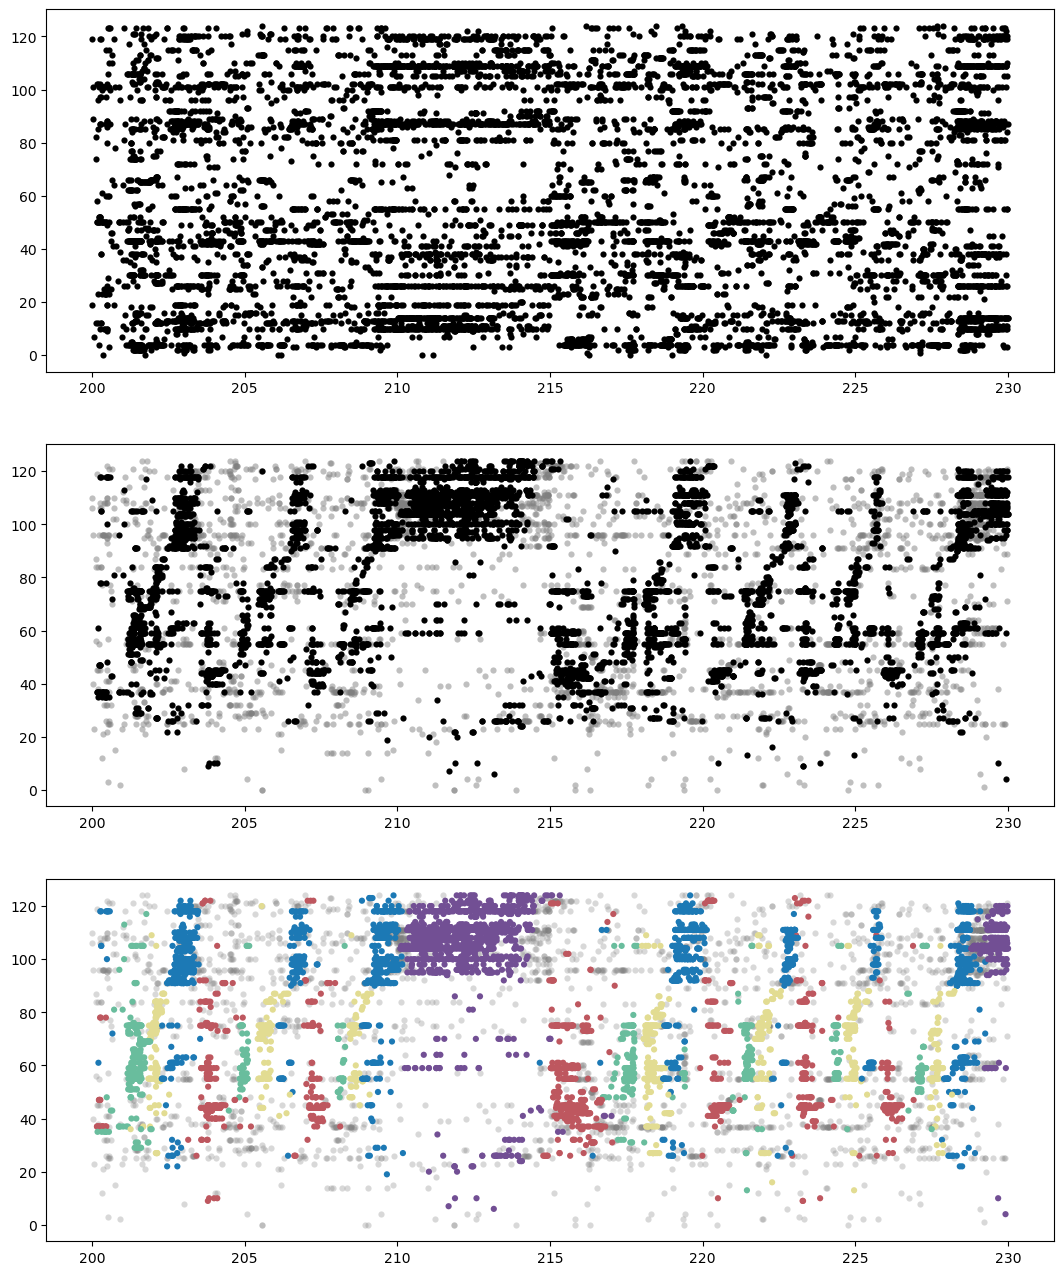

In [2]:
yellow = '#E2DC92'
green = '#69BD9D'
blue = '#1C79B5'
red = '#BE575F'
dark_blue = '#264999'
purple = '#724F94'
gold = '#C6963E'

data = f2_data_dict['example_awake_data_dict']
### change the color ordering to standard color ordering: 
# recolor and save these plots out
current_color_order = [purple, blue, red, gold, yellow, green]
colors = ['---',red,green,yellow,blue,purple,gold,dark_blue]
# ## recolor based on current and desired color order
new_order_inds = [0]
for item in current_color_order:
    new_order_inds += [np.where(np.array(colors) == item)[0][0]]
# apply this ordering
new_colors = colors.copy()
for i,index in enumerate(new_order_inds):
    colors[index] = new_colors[i]                          
# determine new ordering based on this as well
ordering = list((np.array(new_order_inds)-1)[np.array(new_order_inds)-1 >=0])
#swap last 'extra' seq down to the bottom 
ordering = [ordering[-1]] + ordering[0:-1]
print(ordering)

# plot 3 example rasters
plot_unordered_ordered_colored_example(data,ordering, colors)

# figure C

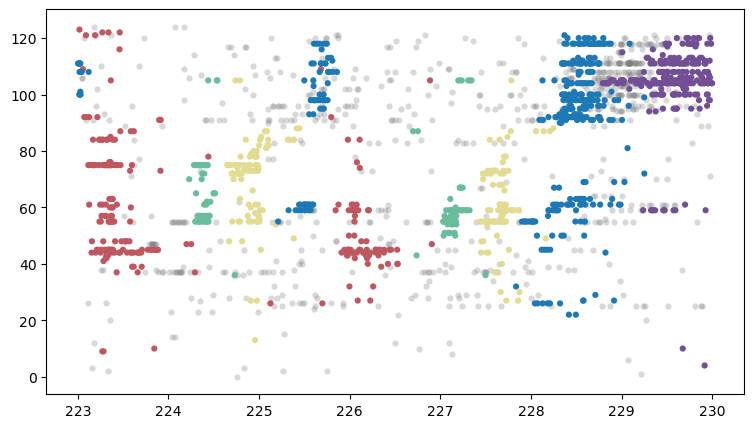

In [3]:
# plot zoomed example
plot_zoomed_example_raster(data,ordering,colors,timeframe = [223,230])

# figure D

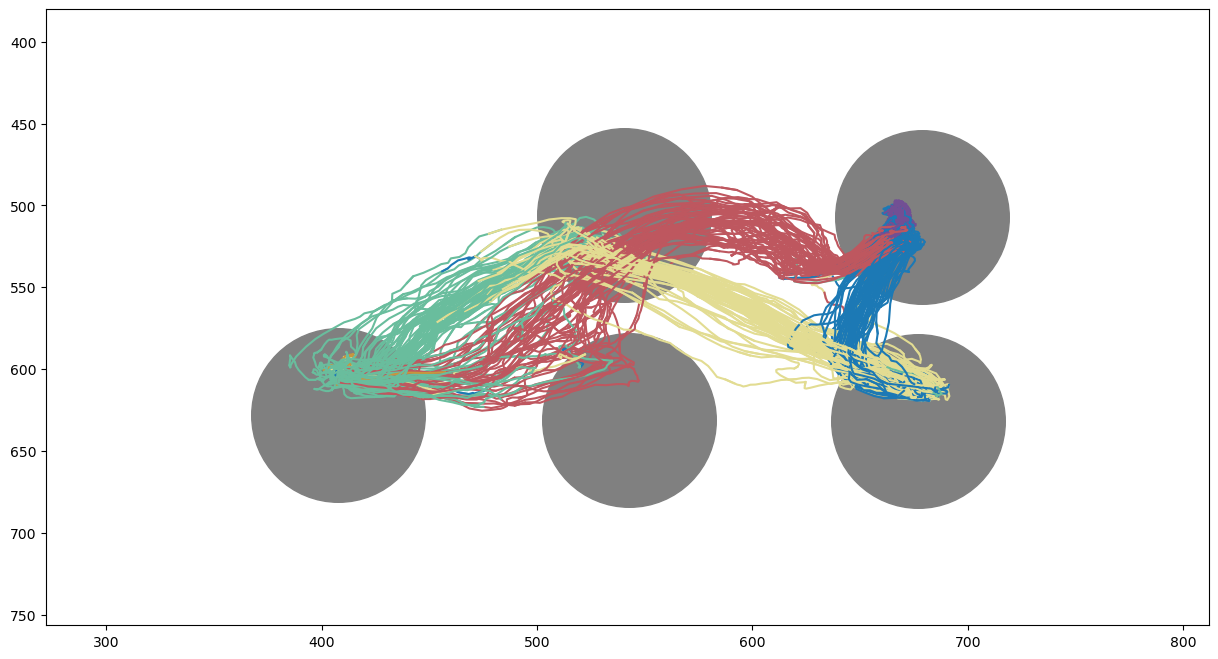

In [4]:
fps = 60
timeframe = [100,400]
bin_size = 0.2

### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(data["spikes_seq_type_adjusted"].sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [data["spikes_seq_type_adjusted"].timestamp[np.where(data["spikes_seq_type_adjusted"].sequence_type_adjusted ==seq_type_)[0]].values]

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(data["behav_time_interval_start"])[0], bin_size))
    seq_spike_occurance += [list(hist)]
    
strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

# behav_mask
mask_ = (data["poke_in_times"] > timeframe[0]) * (data["poke_in_times"] < timeframe[1])

# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 
# Find the difference between PokeIN_EphysTime and the start of the behavior interval

relevant_poke_in_times = data["behav_sync"].PokeIN_EphysTime[data["behav_mask"]][mask_].values
relevant_poke_in_times = [ast.literal_eval(item) for item in relevant_poke_in_times]
interval_pokeIn_spike_times = np.array(relevant_poke_in_times) - data["behav_time_interval_start"][0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  data["behav_sync"].backcam_aligned_pokein_times[data["behav_mask"]][mask_].values[0]
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = ast.literal_eval(interval_cam_times) - tracking_offset

# Calculate the number of events based on the timeframe size and bin size
events = np.diff(timeframe)[0] /bin_size 
# Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
start_ts = [cam_start_time * fps]
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * fps

# Create an empty list for end times
end_ts = []
# Loop through the number of events
for i in range(int(events)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        start_ts += [end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    end_ts += [start_ts[i] + bin_ts] 

## plot tracking colored by dominant ppseq sequence 
plot_tracking_aligned(data,strt_,end_,events,start_ts,end_ts, colors,max_index)
    

# figure E

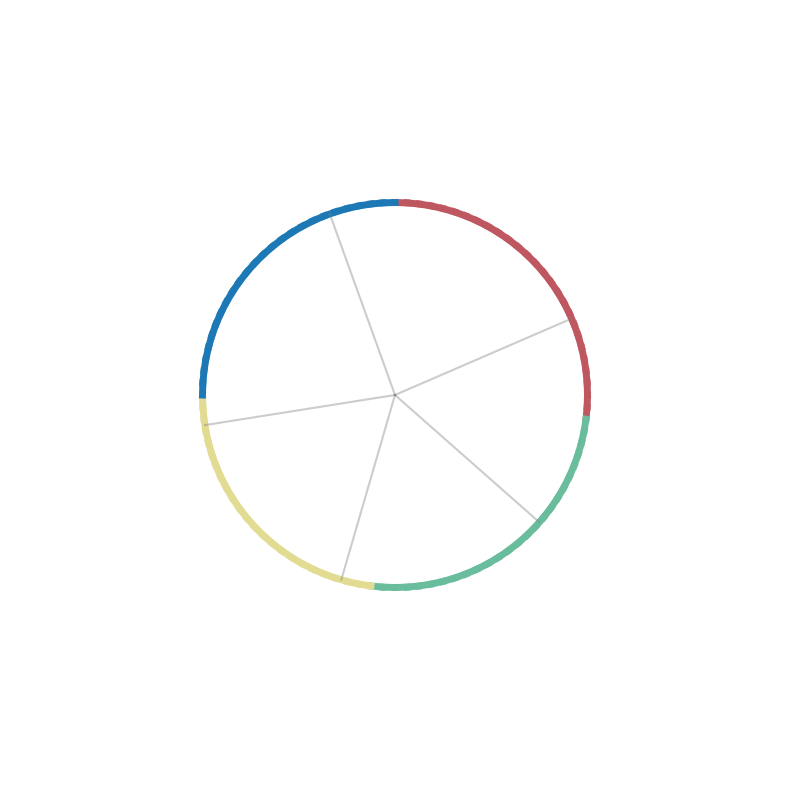

In [5]:
# extract data from dict
warped_x = f2_data_dict['standard_space_dict']['warped_x']
smoothed_counts = f2_data_dict['standard_space_dict']['smoothed_counts']
total_smoothed_counts = np.array(smoothed_counts).sum(axis=0)

# set vars
color_all= []
relabeled_lists= []
colors = ['---',
 '#8FC681',
 '#ABB9B2',
 '#ED6F5D',
 '#64BFB5',
 '#36495E',
 '#FFD161',
 '#264999']

# determine threshold
threshold = 0.2

overlap_positions_standard_space = []
overlap_positions = []

# overlaps with short bouts   
overlap_color = []

for seq in range(6):
    over_thr_mask = (np.array(smoothed_counts[seq])/total_smoothed_counts) > threshold # 20% of the activity is explained by this motif

    # get rid of short isolated motifs
    c = 0
    split_motifs = groupby(over_thr_mask)
    start_over_thr = False
    for over_thr, points in split_motifs:
        if c==0 and over_thr==True: # keep in mind if a fragment of the motif starts from the beginning of the trial 
            start_over_thr = True 
        points = list(points)
        if over_thr==True: # fragment of motif over threshold (over the threshold)
            if len(points) < 10 and c+len(points)<len(over_thr_mask): # too short and not at the extremity
                over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif
                change_made = True
            elif len(points) < 10 and not(start_over_thr): # too short at the right extremity but not at the left extremity
                over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif 
                change_made = True
        c += len(points)
    overlap_color.append(over_thr_mask)

    overlap_positions += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]].astype(int))]

    ###  convert to standard space:
    overlap_positions_standard_space += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]] / len(overlap_color[seq]) * 100)]

v_smoothed_counts= []
for i in range(len(smoothed_counts)):
    v_smoothed_counts += [convolve_movmean(smoothed_counts[i]/total_smoothed_counts,100)]
dominant = []
for bin_ in conactinate_nth_items(v_smoothed_counts):
    dominant += [np.argmax(bin_)+1]


def most_common(lst):
    return max(set(lst), key=lst.count)

comprssed_to_hundred_bins = []
for i in range(100):
    comprssed_to_hundred_bins +=[most_common(list(np.array(dominant)[(warped_x >= i) * (warped_x <= i+1)]))]
color_ = np.array(colors)[comprssed_to_hundred_bins]

new_color_order_for_nice_plotting = ['spacer','#BE575F','#69BD9D','#E2DC92','#1C79B5', '#724F94','#C6963E']

# covert colors back into numbers :
seq_type = []
for i in range(len(color_)):
    index = colors.index(color_[i])
    seq_type += [index]
    
# remove very short blocks ()
result = merge_short_blocks(seq_type,5)

relabeled_list = relabel_list(result)

new_nice_plotting_color_order = np.array(new_color_order_for_nice_plotting)[relabeled_list]

relabeled_lists += [relabeled_list]
color_all += [new_nice_plotting_color_order]
                
x_positions = [18, 36, 54, 72, 94]
rotation_angle = 90  # Rotation angle in degrees

num_rings = 1  # Number of rings
num_segments = 100  # Number of segments in each ring

# Convert rotation angle to radians
rotation_angle_rad = np.deg2rad(rotation_angle)

# Create rotation matrix
rotation_matrix = np.array([
    [np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad)],
    [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad)]
])

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Plot rings
for i in range(num_rings):
    radius = i + 1  # Radius of the ring
    theta = np.linspace(0, 2 * np.pi, num_segments + 1)
    segment_length = 2 * np.pi / num_segments
    mark = (i == num_rings - 1)

    # Plot each segment in the ring
    for j in range(num_segments):
        start_angle = j * segment_length
        end_angle = (j + 1) * segment_length

        x_start, y_start = radius * np.cos(start_angle), radius * np.sin(start_angle)
        x_end, y_end = radius * np.cos(end_angle), radius * np.sin(end_angle)

        # Apply rotation to the start and end points
        start_rotated = np.dot(rotation_matrix, np.array([x_start, y_start]))
        end_rotated = np.dot(rotation_matrix, np.array([x_end, y_end]))

        ax.plot([start_rotated[0], end_rotated[0]], [start_rotated[1], end_rotated[1]], color=color_all[i][j], linewidth=5)

        # Add lines through specified positions on the last ring
        if mark and j in x_positions:
            bisect_x = (start_rotated[0] + end_rotated[0]) / 2
            bisect_y = (start_rotated[1] + end_rotated[1]) / 2
            ax.plot([0, bisect_x], [0, bisect_y], '-', color='grey', alpha=0.4)

# Set plot limits and remove axes
ax.set_xlim(-(num_rings + 1), num_rings + 1)
ax.set_ylim(-(num_rings + 1), num_rings + 1)
ax.axis('off')

# Invert x-axis
ax.invert_xaxis()

# figure F

Text(0.5, 155.72222222222223, 'Start motif')

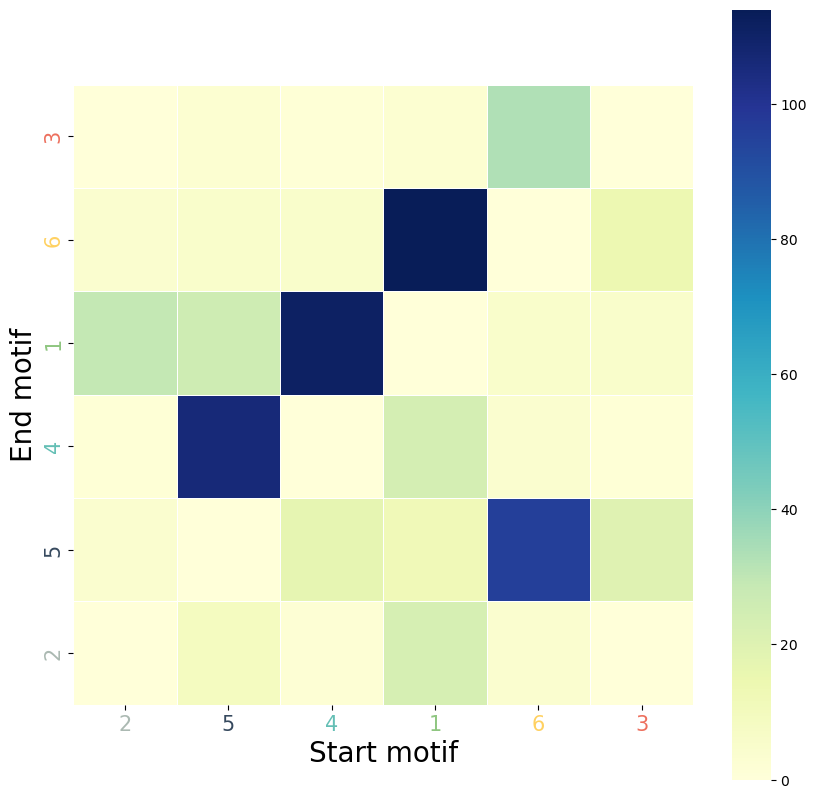

In [6]:
# remove repeats
clean_seqs = remove_neighboring_duplicates(max_index)
# clean_seqs= max_index

possible_transitions = [list((np.unique(clean_seqs)+1)+10)]
for i in range(len(np.unique(clean_seqs))):
    if i > 0:
        possible_transitions += [list(np.array(possible_transitions[i-1]) + 10)]
possible_transitions = [item for sublist in possible_transitions for item in sublist]

# add one to these because dealing with 0-num transitions is difficult and then turn them into 'transition' pairs 
transit_pairs = create_pairs(np.array(clean_seqs)+1)

transition_number = determineTransitionNumber(transit_pairs,possible_transitions)

transitions_shaped = np.reshape(transition_number,(6,6))

# Reorder the array base don ordering defined earlier 
reordered_array = transitions_shaped[ordering]
reordered_array = reordered_array[:,ordering]
reordered_array = reordered_array.T[::-1]


order_strings = [str(num) for num in list(np.array(ordering) +1)]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
h1 = sns.heatmap(reordered_array, linewidths=.5,xticklabels= order_strings, yticklabels=order_strings[::-1], square=True,cmap="YlGnBu",fmt = '',cbar_kws = dict(use_gridspec=False,location="right"))

# color labels by motif/seq colour
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    tick_label.set_color(colors[ordering[::-1][i]+1])
    tick_label.set_fontsize("15")
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    tick_label.set_color(colors[ordering[i]+1])
    tick_label.set_fontsize("15")
    
    
ax.set_ylabel('End motif',size = 20)
ax.set_xlabel('Start motif',size = 20)

# figure G

1
3
4
5
6


  0%|          | 0/125 [00:00<?, ?it/s]C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60332\4249729650.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  resp_prob_1 += [float(current_data.x1)]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60332\4249729650.py:97: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  resp_prob_2 += [float(current_data.x2)]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60332\4249729650.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  resp_prob_3 += [float(current_data.x3)]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_60332\4249729650.py:99: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

0
1
2
3
111
111
111
111


(-3.0, 6.0)

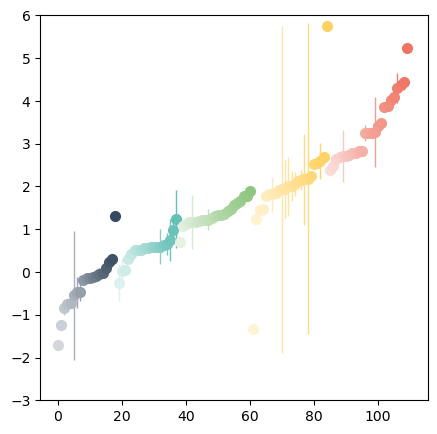

In [7]:
logical_order = f2_data_dict['logical_order']


#### define when seqs occur and label neurons that contribute to them 
seq_size_threshold= 5
unmasked_spikes_df = data["spikes_seq_type_adjusted"]
all_seq_neurons = []  
df_seq_inds = []
total_seqs_by_type =[]
seq_numbers_passed = []
current_order = []
all_mid_point_times = []
for i in range(1,7):
    if i-1 in logical_order:
        print(i)
        seq_spike_count = seq_spike_occurance[i]
        # find seq start and end, defined by whetehr there were spikes or not 
        groups = return_inds_for_seq_groups(seq_spike_count)
        #mask
        # spikemask
        timeframe = [0,800]
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        seq_neurons = []
        df_index = []
        mid_point_time = []
        counter = 0
        for group in groups:
            # spikemask
            timeframe = [(group[0] * bin_size)-0.5,(group[-1] * bin_size)+0.5]
            mid_point_time += [timeframe[0] + (np.diff(timeframe)[0]/2)]
            mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
            seq_mask = unmasked_spikes_df[mask].sequence_type_adjusted == i
            if len(unmasked_spikes_df[mask][seq_mask]) > seq_size_threshold:
                counter +=1
                seq_neurons.append(list(unmasked_spikes_df[mask][seq_mask].neuron))
                df_index += [list(unmasked_spikes_df[mask][seq_mask].index)]
        total_seqs_by_type += [counter]
        all_seq_neurons.append(seq_neurons)
        df_seq_inds.append(df_index)
        all_mid_point_times += [mid_point_time]
        
        current_order +=[i]
        
## determine number of sequences each neuron appears in 
neuron_id = []
percentage_breakdown = []
dominant_percentage = []
seqs_unique = []
dominant_seq = []
# loop across neurons 
for neuron_ in unmasked_spikes_df.neuron.unique():
    
    current_neuron_mask = unmasked_spikes_df.neuron == neuron_
    seq_type_appearances = unmasked_spikes_df[current_neuron_mask].sequence_type_adjusted.values.astype(int)

    #n percentage spikes that are background:
    len(seq_type_appearances[seq_type_appearances < 0])/len(seq_type_appearances)
    
    #percentage split across 
    background_remove = seq_type_appearances > 0
    seq_type_appearances[background_remove]

    seq_appearnce= []
    count = []
    
    # if not background:
    if not len(seq_type_appearances[background_remove]) == 0:     
        
        seqs_unique.append(list(np.unique(seq_type_appearances[background_remove])))
        for seq in np.unique(seq_type_appearances[background_remove]):
            seq_appearnce.append(seq)
            count.append(list(seq_type_appearances[background_remove]).count(seq))

        percentage_breakdown.append(calculate_percentages(count))
        dominant_percentage.append(max(calculate_percentages(count)))
        dominant_seq.append(np.unique(seq_type_appearances[background_remove])[np.argmax(calculate_percentages(count))])
        neuron_id.append(neuron_)


N_neurons= data["bkgd_log_proportions_array"].shape[1]

# Iterate through the range
concat_data_rp = []
concat_data_o = []
for neuron in tqdm(range(N_neurons)):
    
    resp_prob_1, resp_prob_2, resp_prob_3, resp_prob_4, resp_prob_5, resp_prob_6 = [],[],[],[],[],[]
    offset_1, offset_2, offset_3, offset_4, offset_5, offset_6 = [],[],[],[],[],[]
    
    for iteration_ in range(400, 500):
        index_ = neuron + (N_neurons *  iteration_)
        current_data = data["neuron_response_df"].loc[data["neuron_response_df"].index == index_]
        
        resp_prob_1 += [float(current_data.x1)]
        resp_prob_2 += [float(current_data.x2)]
        resp_prob_3 += [float(current_data.x3)]
        resp_prob_4 += [float(current_data.x4)]
        resp_prob_5 += [float(current_data.x5)]
        resp_prob_6 += [float(current_data.x6)]
        
        offset_1 += [current_data.x7]
        offset_2 += [current_data.x8]
        offset_3 += [current_data.x9]
        offset_4 += [current_data.x10]
        offset_5 += [current_data.x11]
        offset_6 += [current_data.x12]
         
    new_row = [neuron+1,resp_prob_1,resp_prob_2,resp_prob_3,resp_prob_4,resp_prob_5,resp_prob_6]
    concat_data_rp.append(new_row)
    
    new_row = [neuron+1,offset_1,offset_2,offset_3,offset_4,offset_5,offset_6]
    concat_data_o.append(new_row)

resp_prop_df = pd.DataFrame(concat_data_rp, columns = ['neuron','response_prob_1','response_prob_2','response_prob_3','response_prob_4','response_prob_5','response_prob_6'])
offset_df = pd.DataFrame(concat_data_o, columns = ['neuron','offset_1','offset_2','offset_3','offset_4','offset_5','offset_6'])


### order these by average distance between motifs
threshold = 2 #seconds

combined_events = []
seq_type_labels = []
for index,events in enumerate(all_mid_point_times):
    combined_events += events
    seq_type_labels += [np.array(sorted(logical_order))[index]]*len(events)
    
sorted_events = list(np.array(combined_events)[np.argsort(combined_events)])
sorted_labels = list(np.array(seq_type_labels)[np.argsort(combined_events)])

all_gaps = []
for e in range(len(logical_order)-1):
    print(e)
    occurance_inds = find_sequence(sorted_labels,[logical_order[e],logical_order[e+1]])

    gap = []
    for i in range(len(occurance_inds)):
        current_gap = np.diff(sorted_events[occurance_inds[i]:occurance_inds[i]+2])[0]
        if current_gap < threshold:
            gap += [current_gap]
    all_gaps += [gap]
    
gap_means = []
for gap in all_gaps:
    gap_means += [np.mean(gap)]
    
all_mean_mean_offset,all_sem_mean_offset,all_index_o = calculate_mean_sem_of_neuron_seq_repsonses(offset_df,'offset')
    
### plot:

all_offsets = []
all_colors = []
all_e_bars = []

for index in range(6):
    seq = index + 1
    neuron_include  = []
    for index,neuron_seqs in enumerate(seqs_unique):
        if seq in neuron_seqs:
            p_occurance = percentage_breakdown[index][np.where(np.array(neuron_seqs) == seq)[0][0]]
            if p_occurance > threshold:
                current_neuron = neuron_id[index]
                if current_neuron in list(np.array(neuron_id)[np.array(dominant_seq) == seq]):
                    neuron_include.append(index)
                
    offsets = np.array(all_mean_mean_offset)[np.array(neuron_include)][:,seq-1]
    e_bars = np.array(all_sem_mean_offset)[np.array(neuron_include)][:,seq-1]

    x = list(range(0,len(offsets)))
    y = sorted(offsets)
    
    color_gradient = create_color_gradient('white', colors[seq], len(x))
    intermediate_color = color_gradient[int(len(color_gradient) *0.25)]
    color_gradient = create_color_gradient(intermediate_color, colors[seq], len(x))
    
    all_offsets+=[y]
    all_colors+=[color_gradient]
    all_e_bars += [e_bars]
    
new_order, missing_count = add_missing_numbers(logical_order, 0, 5)
new_order = np.array([4, 3, 0, 5, 2,1])

reordered_all_offsets = reorder_lists(all_offsets,new_order)
reordered_all_e_bars = reorder_lists(all_e_bars,new_order)
reordered_all_all_colors = reorder_lists(all_colors,new_order)

## add in gaps
for i in range(len(np.cumsum(gap_means))):
    reordered_all_offsets[i+1] = list(np.array(reordered_all_offsets[i+1]) + np.cumsum(gap_means)[i])

    flat_offsets = [item for sublist in reordered_all_offsets[0:-missing_count] for item in sublist]
    flat_e_bars = [item for sublist in reordered_all_e_bars[0:-missing_count] for item in sublist]
    flat_colors_grads = [item for sublist in reordered_all_all_colors[0:-missing_count] for item in sublist]
    x = np.linspace(0 ,len(flat_offsets)-1,len(flat_offsets))
    
    print(len(x))

fig, ax = plt.subplots(1, 1,figsize=(5, 5))
for i,y in enumerate(flat_offsets):
    ax.errorbar(x[i],y, yerr=flat_e_bars[i], fmt='o', c = flat_colors_grads[i],markersize = 7, linewidth = 1)
ax.set_ylim(-3,6)
    

# figure H

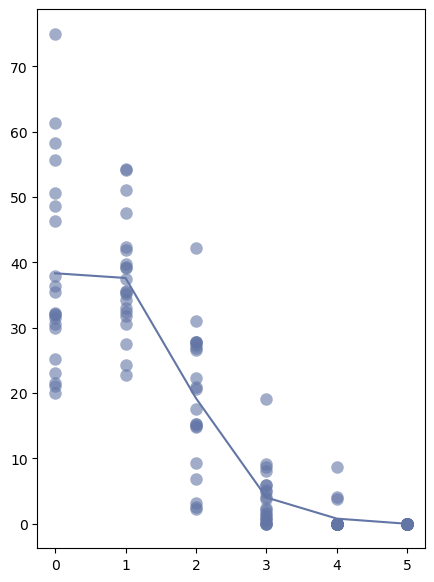

In [8]:
Num_seqs_neurons_appeared_in_a_a = f2_data_dict['latent_composition_dict']['Num_seqs_neurons_appeared_in_a_a']

# plot number of sequences neurons appear in as percentage of spikes
means = []
fig,ax= plt.subplots(1, 1,figsize=(5, 7))
for index,item in enumerate(conactinate_nth_items(Num_seqs_neurons_appeared_in_a_a)):
    ax.plot([index]*len(item),item,'o', color = '#6275A5', markersize = 9,alpha = 0.6, markeredgewidth=0.0)#
    means += [np.mean(item)]
ax.plot(means,'-', color = '#6275A5')


# figure I

(0.0, 1.0)

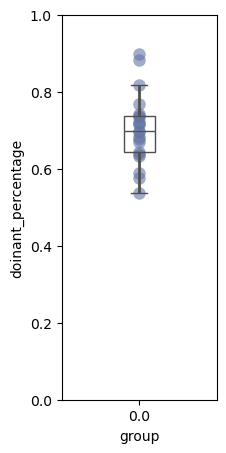

In [9]:
dominance_a_a = f2_data_dict['latent_composition_dict']['dominance_a_a']

### donimant proportion 
fig,ax= plt.subplots(1, 1,figsize=(2, 5))
means = []
for list_doms in dominance_a_a:
    means += [np.nanmean(list_doms)]
ax.plot(np.zeros(len(means)),means,'o',color = '#6275A5', markersize = 9,alpha = 0.6, markeredgewidth=0.0)

plot_df = pd.DataFrame({'group': np.zeros(len(means)), 'doinant_percentage': means}, )

ax=sns.boxplot( y = 'doinant_percentage', x = 'group', data = plot_df, color = '#6275A5', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
ax.set_ylim(0,1)


# figure J

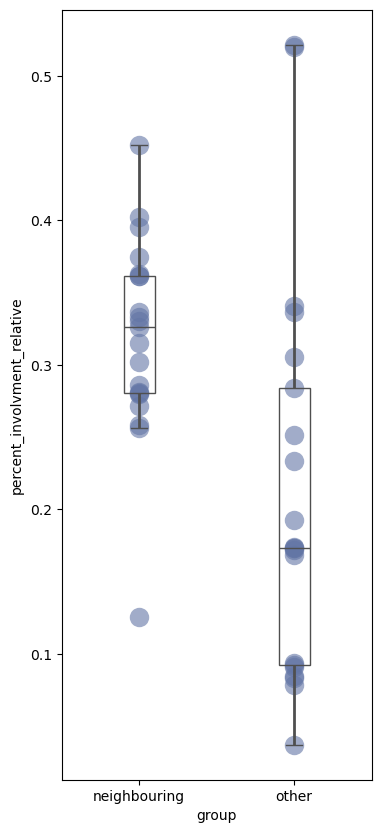

In [10]:
non_neighbor_proportions_a_a = f2_data_dict['latent_composition_dict']['non_neighbor_proportions_a_a']
neighbor_proportions_a_a = f2_data_dict['latent_composition_dict']['neighbor_proportions_a_a']

non_neighbor_means = []
neighbor_means = []
for index,item in enumerate(non_neighbor_proportions_a_a):
    non_neighbor_means += [np.nanmean(item)]
    neighbor_means += [np.nanmean(neighbor_proportions_a_a[index])]


fig,ax= plt.subplots(1, 1,figsize=(4, 10))
ax.plot(np.ones(len(non_neighbor_means)),non_neighbor_means,'o',color = '#6275A5', markersize = 14,alpha = 0.6, markeredgewidth=0.0 )


ax.plot(np.zeros(len(neighbor_means)),neighbor_means,'o',color = '#6275A5', markersize = 14,alpha = 0.6, markeredgewidth=0.0 )

plot_df = pd.DataFrame({'group': (['neighbouring']*len(neighbor_means)) + (['other']*len(non_neighbor_means)), 'percent_involvment_relative': neighbor_means+non_neighbor_means})

ax=sns.boxplot( y = 'percent_involvment_relative', x = 'group', data = plot_df, color = '#6275A5', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

